In [61]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [52]:
# Helper function to make sexy axes for pressure levels
def sexy_axes2(ax, fs, ylab, xlab):
    ax.set_ylim([50,800])
    ax.set_yscale('log')
    ax.set_yticks([800,500,300,100])
    ax.set_yticklabels(['800','500','300','100'])
    if xlab == True:
        ax.set_xlabel(r'Cloud-radiative heating [K day$^{-1}$]',fontsize=fs-2)
    if ylab == True:
        ax.set_ylabel('Pressure [hPa]',fontsize=fs)
    ax.invert_yaxis()
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left') 
    ax.tick_params('both',labelsize=fs,rotation=45)

# Figure S1: Diurnal cycle in LW / SW heating rates

In [53]:
# Load heating rates for 1- and 2-moments, 24-hours, LW + SW, and 120 pressure levels.
H = np.zeros((2,24,2,120))
H[0] = np.load('./output/H_1mom_PL2.npy')
H[1] = np.load('./output/H_2mom_PL2.npy')
colors = plt.cm.jet(np.linspace(0,1,24))

# Load the pressure levels
pl = np.loadtxt('./remapping/PMEAN_48-72.txt')

# Labels
let = [['(a) \n 1-mom LW', '(c) \n 1-mom SW'],['(b) \n 2-mom LW', '(d) \n 2-mom SW']]

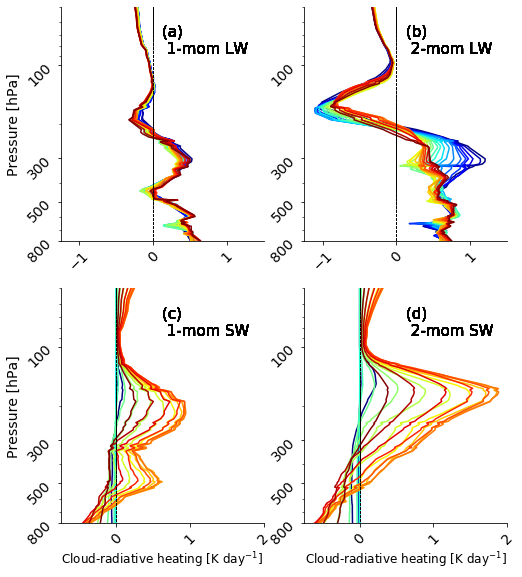

In [57]:
fs = 14
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(8,9.5))
for j in [0,1]:
    for i in np.arange(24):
        ax[0,j].plot(H[j,i,0],pl/100,color=colors[i])
        ax[1,j].plot(H[j,i,1],pl/100,color=colors[i])
        ax[0,j].plot([0,0],[50,1000], lw=0.75, linestyle='--', color='k')
        ax[1,j].plot([0,0],[50,1000], lw=0.75, linestyle='--', color='k')
        ax[0,j].set_xlim([-1.25,1.5])
        ax[1,j].set_xlim([-0.75,2])
        ax[0,j].text(0.5,0.8,let[j][0],fontsize=fs+1,transform=ax[0,j].transAxes)
        ax[1,j].text(0.5,0.8,let[j][1],fontsize=fs+1,transform=ax[1,j].transAxes)
        
    sexy_axes2(ax[0,j], fs, j+1, False)
    sexy_axes2(ax[1,j], fs, j+1, True)
    
fig.savefig('./output/2-diurnal-cycle.pdf',bbox_inches='tight')

# Fig S2: IWP distribution and ice mass absorption coefficient

In [84]:
# Load the integrated column ice values from the 1- and 2-moment simulations
basedir = '/work/bb1018/b380873/model_output/ICON/'
TQI_fi = xr.open_dataset(basedir + 'TQI_ALL_0.025deg_tropic_run2.nc')
TQI_1mom = TQI_fi.tqi.sel(lon=slice(55,115)).values.flatten()
TQI_1mom = TQI_1mom[(TQI_1mom >= 10**(-7)) & (TQI_1mom <= 10)]

basedir = '/work/bb1018/b380873/model_output/ICON/'
TQI_fi = xr.open_dataset(basedir + 'TQI_120-141_0.025deg_tropic_run5.nc')
TQI_2mom = TQI_fi.tqi.values.flatten()
TQI_2mom = TQI_2mom[(TQI_2mom >= 10**(-7)) & (TQI_2mom <= 10)]

print(np.nanmean(TQI_2mom))
print(np.nanmean(TQI_1mom))

0.08207787
0.017379055


In [87]:
# Ice density [kg m-3]
rho_ice = 920

ice_opt = np.genfromtxt('/work/bb1018/b380873/rrtm/output/ice_optical_properties.txt')
# Wavelength [um]
lamb = ice_opt[:,0]
# Wavenumbers [cm-1] as above
wn_ice = 1./lamb*10**(4)
# Imaginary part of the index of refraction
mim = ice_opt[:,2]
# Calculate the ice mass absorption coefficient from m_im. [m2 kg-1]
# Note that we have to make an assumption about ice density here.
sigma_ice = 4*np.pi*mim/(lamb*10**(-6))/rho_ice

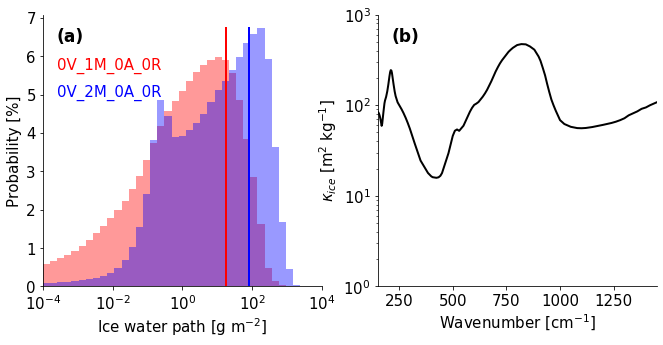

In [95]:
fs = 15
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,5))
d = -4; u = 4; b = 40
wgts = np.ones_like(TQI_1mom)/float(len(TQI_1mom))*100
sns.distplot(TQI_1mom*1000, kde=False, hist=True, kde_kws={'shade':True,'linewidth':3},\
   label=r'1-mom', bins=np.logspace(d,u,b), color='r', hist_kws={'weights':wgts}, ax=ax[0])

wgts = np.ones_like(TQI_2mom)/float(len(TQI_2mom))*100
sns.distplot(TQI_2mom*1000, kde=False, hist=True, kde_kws={'shade':True,'linewidth':3},\
   label=r'2-mom', bins=np.logspace(d,u,b), color='b', hist_kws={'weights':wgts}, ax = ax[0])

ax[0].plot([np.nanmean(TQI_1mom)*1000, np.nanmean(TQI_1mom)*1000],[0,6.75],color='red',linewidth=2)
ax[0].plot([np.nanmean(TQI_2mom)*1000, np.nanmean(TQI_2mom)*1000],[0,6.75],color='blue',linewidth=2)
ax[0].set_xscale('log')
ax[0].set_xlim([10**(-4),10**4])
ax[0].set_xlabel(r'Ice water path [g m$^{-2}$]',fontsize=fs)
ax[0].set_ylabel('Probability [%]',fontsize=fs)
ax[0].text(0.05,0.9,'(a)',weight='bold',fontsize=fs+2,transform=ax[0].transAxes)
ax[0].text(0.05,0.8,'0V_1M_0A_0R',fontsize=fs,color='red',transform=ax[0].transAxes)
ax[0].text(0.05,0.7,'0V_2M_0A_0R',fontsize=fs,color='blue',transform=ax[0].transAxes)
ax[0].tick_params('both',labelsize=fs)
ax[0].spines['right'].set_color('none')
ax[0].spines['top'].set_color('none')

ax[1].plot(wn_ice,sigma_ice,color='k',linewidth=2)
ax[1].text(0.05,0.9,'(b)',weight='bold',fontsize=fs+2,transform=ax[1].transAxes)
ax[1].set_xlabel(r'Wavenumber [cm$^{-1}$]',fontsize=fs)
ax[1].set_ylabel(r'$\kappa_{ice}$ [m$^{2}$ kg$^{-1}$]',fontsize=fs)
ax[1].set_yscale('log')
ax[1].tick_params(labelsize=fs,axis='both',which='major')
ax[1].set_xlim([150,1450])  # infrared range
ax[1].set_ylim([1,1000]) # infrared range
ax[1].tick_params(labelsize=fs)
ax[1].spines['right'].set_color('none')
ax[1].spines['top'].set_color('none')

fig.savefig('./output/2-iwp-kappa-ice.pdf')

# Fig S3: Vertical velocity profiles

In [98]:
# Load the vertical velocity values
WT_2mom = np.load('./output/WT_2mom_PL2.npy')
WT_1mom = np.load('./output/WT_1mom_PL2.npy')
WT_no2mom = np.load('./output/WT_no2mom_PL2.npy')
WT_novgrid = np.load('./output/WT_novgrid_PL2.npy')

# Retrieve the pressure levels
pl = np.loadtxt('./remapping/PMEAN_48-72.txt')

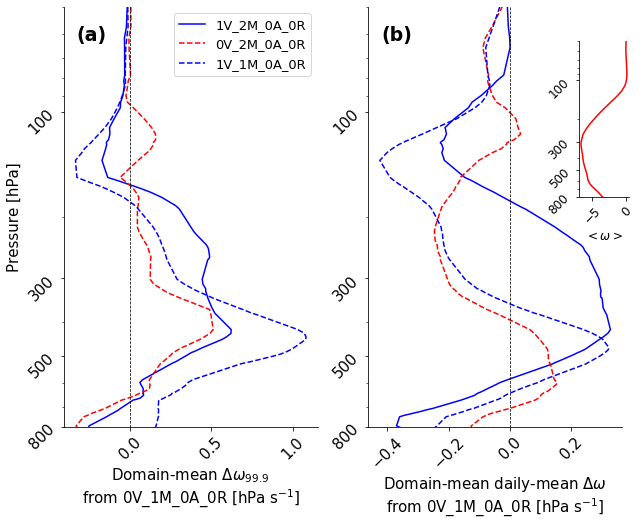

In [136]:
fs = 15
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,8))
p = 0.01
#ax[0].plot(np.percentile(WT_1mom[:,0],1,axis=0),pl/100,color='red',label='ICON-1mom')
ax[0].plot((np.percentile(WT_2mom[:,0],p,axis=0)-np.percentile(WT_1mom[:,0],p,axis=0))*100,\
       pl/100,color='blue',label='1V_2M_0A_0R')
ax[0].plot((np.percentile(WT_no2mom[:,0],p,axis=0)-np.percentile(WT_1mom[:,0],p,axis=0))*100,\
       pl/100,color='red',linestyle='--',label='0V_2M_0A_0R')
ax[0].plot((np.percentile(WT_novgrid[:,0],p,axis=0)-np.percentile(WT_1mom[:,0],p,axis=0))*100,\
       pl/100,color='blue',linestyle='--',label='1V_1M_0A_0R')
ax[0].plot([0,0],[50,800],lw=0.75,linestyle='--',color='k')
ax[0].set_ylabel('Pressure [hPa]',fontsize=fs)
ax[0].set_xlabel(r'Domain-mean $\Delta\omega_{99.9}$ '
                  '\n'
                 'from 0V_1M_0A_0R [hPa s$^{-1}$]',fontsize=fs)
ax[0].text(0.05,0.92,'(a)',weight='bold',fontsize=fs+4,transform=ax[0].transAxes)
sexy_axes2(ax[0], fs, True, False)
ax[0].legend(loc='upper right',fontsize=fs-2)

ax[1].plot((np.nanmean(WT_2mom[:,0],axis=0)-np.nanmean(WT_1mom[:,0],axis=0))*100,pl/100,\
       color='blue')
ax[1].plot((np.nanmean(WT_no2mom[:,0],axis=0)-np.nanmean(WT_1mom[:,0],axis=0))*100,pl/100,\
       color='red',linestyle='--')
ax[1].plot((np.nanmean(WT_novgrid[:,0],axis=0)-np.nanmean(WT_1mom[:,0],axis=0))*100,pl/100,\
       color='blue',linestyle='--')
ax[1].plot([0,0],[50,800],lw=0.75,linestyle='--',color='k')
ax[1].set_xlabel(r'Domain-mean daily-mean $\Delta\omega$'
                 '\n'
                 'from 0V_1M_0A_0R [hPa s$^{-1}$]',fontsize=fs)
ax[1].text(0.05,0.92,'(b)',weight='bold',fontsize=fs+4,transform=ax[1].transAxes)
sexy_axes2(ax[1],fs,False,False)

ax2 = fig.add_axes([0.84,0.55,0.07,0.27])
ax2.plot(np.nanmean(WT_1mom[:,0],axis=0)*100,pl/100,color='red',label='_nolegend_')
ax2.set_xlabel('$<\omega>$',fontsize=fs-3)
sexy_axes2(ax2,fs-3,False,False)
plt.gcf().subplots_adjust(bottom=0.15)

fig.savefig('./output/2-w-profiles.pdf')